In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gp import *
import time
from scipy.stats import multivariate_normal

In [5]:
z_train = np.arange(-5,6,1).reshape(-1,1)
y_train = z_train**2


z_query = np.arange(-10,10,0.1).reshape(-1,1)

theta0 = [1,1,1] # Kernel variables
n_sample_function = 5

model_prior = GPR(None, None, covariance_function=KernelFunction, theta=theta0)
mean_prior, cov_prior = model_prior.predict(z_query, cov=True)
std_prior = np.diag(cov_prior)

y_samples_prior = model_prior.draw_function_sample(z_query, n_sample_function)
#y_query = np.random.multivariate_normal(mean=mean_prior.ravel(), cov=covar_prior, size=n_sample_function)


model_posterior = GPR(z_train, y_train, covariance_function=KernelFunction, theta=theta0)
# Before ML optimization
mean_b, cov_b = model_posterior.predict(z_query, cov=True)
std_b = np.diag(cov_b)
y_samples_b = model_posterior.draw_function_sample(z_query, n_sample_function)

# ML optimization
model_posterior.fit()

# After optimization
mean_a, cov_a = model_posterior.predict(z_query, cov=True)
std_a = np.diag(cov_a)
y_samples_a = model_posterior.draw_function_sample(z_query, n_sample_function)


# Casadi 
z_sample_cs = cs.SX.sym('x_sample', z_query.shape[0], 1)
y_predict_cs = model_posterior.predict(z_sample_cs)

#f_eval_cs = cs.Function('f', [z_sample_cs], [y_predict_cs])
grad_y = cs.jacobian(y_predict_cs, z_sample_cs)

# Symbolic diferentiation
# Create a Function to evaluate expression
f = cs.Function('f',[z_sample_cs],[grad_y])
grad_y_eval = f(z_query)

Size of feature training data = (0, 1)
Size of output training data = (0, 1)
(0, 0)
(200, 200)
(0, 0)
(200, 200)
Size of feature training data = (11, 1)
Size of output training data = (11, 1)


/home/ja/Projects/MPC_drone/mpc_quad/gp/gp.py:246: RuntimeWarning: invalid value encountered in multiply
  cov_mat = np.empty((x1.shape[0], x2.shape[0]))*np.NaN


(11, 200)
(200, 200)
(11, 200)
(200, 200)
Maximizing the likelyhood function for GP
Hyperparameters before optimization = [1, 1, 1]
Size of feature training data = (11, 1)
Size of output training data = (11, 1)
Optimization done
Hyperparameters after optimization = [1.46741320e+01 1.17245832e+02 1.00000000e-02]
(11, 200)
(200, 200)
(11, 200)
(200, 200)


/home/ja/Projects/MPC_drone/mpc_quad/gp/gp.py:171: RuntimeWarning: covariance is not positive-semidefinite.
  y_sample = np.random.multivariate_normal(mean=mean_at_values.ravel(), cov=cov_matrix, size=n_sample_functions)


(11, 200)
(200, 200)


Text(0.5, 1.0, 'Covariance matrix $\\Sigma$')

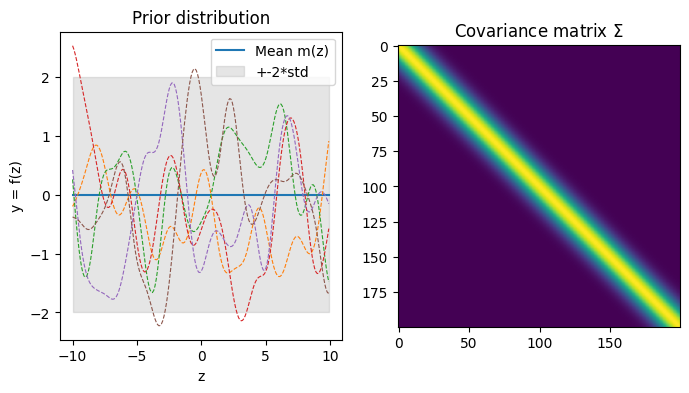

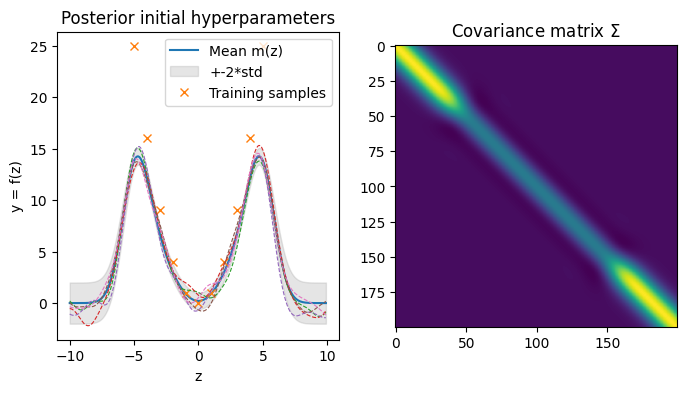

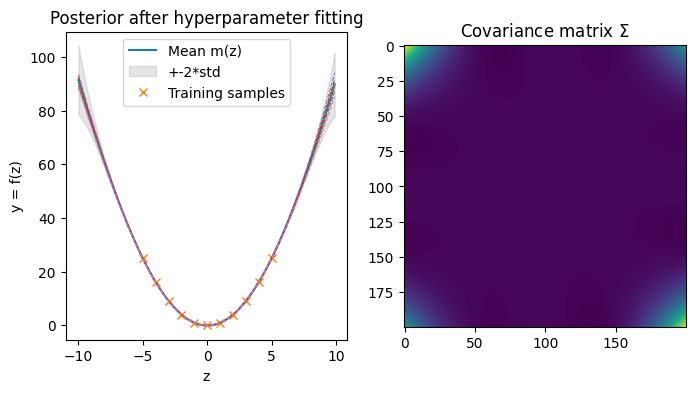

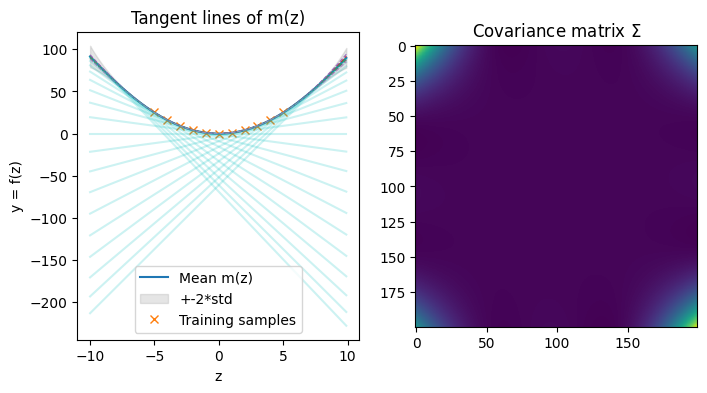

In [10]:
plt.figure(figsize=(8,4), dpi=100)
plt.subplot(1,2,1)
plt.plot(z_query, mean_prior)
plt.fill_between(z_query.reshape(-1), mean_prior.reshape(-1) - 2*std_prior, mean_prior.reshape(-1) + 2*std_prior, color='gray', alpha=0.2)

for i in range(y_samples_prior.shape[0]):
    plt.plot(z_query, y_samples_prior[i], '--', linewidth=0.8)

plt.xlabel('z')
plt.ylabel('y = f(z)')
plt.legend(('Mean m(z)', '+-2*std'))
plt.title('Prior distribution')

plt.subplot(1,2,2)
plt.title('Covariance matrix $\Sigma$')
plt.imshow(cov_prior)

plt.figure(figsize=(8,4), dpi=100)
plt.subplot(1,2,1)
plt.plot(z_query, mean_b)
plt.fill_between(z_query.reshape(-1), mean_b.reshape(-1) - 2*std_b, mean_b.reshape(-1) + 2*std_b, color='gray', alpha=0.2)
plt.plot(z_train, y_train, 'x')

for i in range(y_samples_b.shape[0]):
    plt.plot(z_query, y_samples_b[i],'--', linewidth=0.8)
plt.xlabel('z')
plt.ylabel('y = f(z)')
plt.legend(('Mean m(z)', '+-2*std', 'Training samples'))
plt.title('Posterior initial hyperparameters')
plt.subplot(1,2,2)
plt.imshow(cov_b)
plt.title('Covariance matrix $\Sigma$')


plt.figure(figsize=(8,4), dpi=100)
plt.subplot(1,2,1)
plt.plot(z_query, mean_a)
plt.fill_between(z_query.reshape(-1), mean_a.reshape(-1) - 2*std_a, mean_a.reshape(-1) + 2*std_a, color='gray', alpha=0.2)
plt.plot(z_train, y_train, 'x')
for i in range(y_samples_a.shape[0]):
    plt.plot(z_query, y_samples_a[i],'--', linewidth=0.8)
    

plt.xlabel('z')
plt.ylabel('y = f(z)')
plt.legend(('Mean m(z)', '+-2*std', 'Training samples'))
plt.title('Posterior after hyperparameter fitting')
plt.subplot(1,2,2)
plt.imshow(cov_a)
plt.title('Covariance matrix $\Sigma$')


plt.figure(figsize=(8,4), dpi=100)
plt.subplot(1,2,1)
plt.plot(z_query, mean_a)
plt.fill_between(z_query.reshape(-1), mean_a.reshape(-1) - 2*std_a, mean_a.reshape(-1) + 2*std_a, color='gray', alpha=0.2)
plt.plot(z_train, y_train, 'x')
for i in range(y_samples_a.shape[0]):
    plt.plot(z_query, y_samples_a[i],'--', linewidth=0.8)

# Plot tangent lines
for i in range(0,200,10):
    y_line = grad_y_eval[i,i]*z_query+mean_a[i]- grad_y_eval[i,i]*z_query[i]
    plt.plot(z_query, y_line, alpha=0.2, c='c')

plt.xlabel('z')
plt.ylabel('y = f(z)')
plt.legend(('Mean m(z)', '+-2*std', 'Training samples'))
plt.title('Tangent lines of m(z)')
plt.subplot(1,2,2)
plt.imshow(cov_a)
plt.title('Covariance matrix $\Sigma$')